In [1]:
import os
# from multiprocessing import Pool
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import starships.planet_obs as pl_obs
from astropy import units as u
from starships import correlation as corr
from starships.orbite import rv_theo_t
from starships.planet_obs import Observations

from logl_analysis import get_logl

# seed the random number generator
rstate = np.random.default_rng(736109)


petitRADTRANS is not installed on this system
petitRADTRANS is not installed on this system


In [2]:
!ls ~/scratch/DataAnalysis/SPIRou/Reductions/WASP-127b_genest

retrieval_input_3-pc_mask_wings90_tr1_data_info.npz
retrieval_input_3-pc_mask_wings90_tr1_data_trs_0.npz


In [3]:
# Use scratch if available, use home if not.
try:
    base_dir = Path(os.environ['SCRATCH'])
except KeyError:
    base_dir = Path.home()

# Where the reduced data is saved
high_res_path = base_dir / Path(f'DataAnalysis/SPIRou/Reductions/WASP-127b_genest')

# The stem of the files where the infos are saved (retrieval ready files)
high_res_file_stem = f'retrieval_input_3-pc_mask_wings90_tr1'


In [4]:
path_model_file = Path('.')
specfile = Path('WASP-127b_best_fit_H2O_no_convolution.npz')


# Read the model file.
model_file = np.load(path_model_file / specfile)
wv_high, model_high = model_file['wl'], model_file['dppm']

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


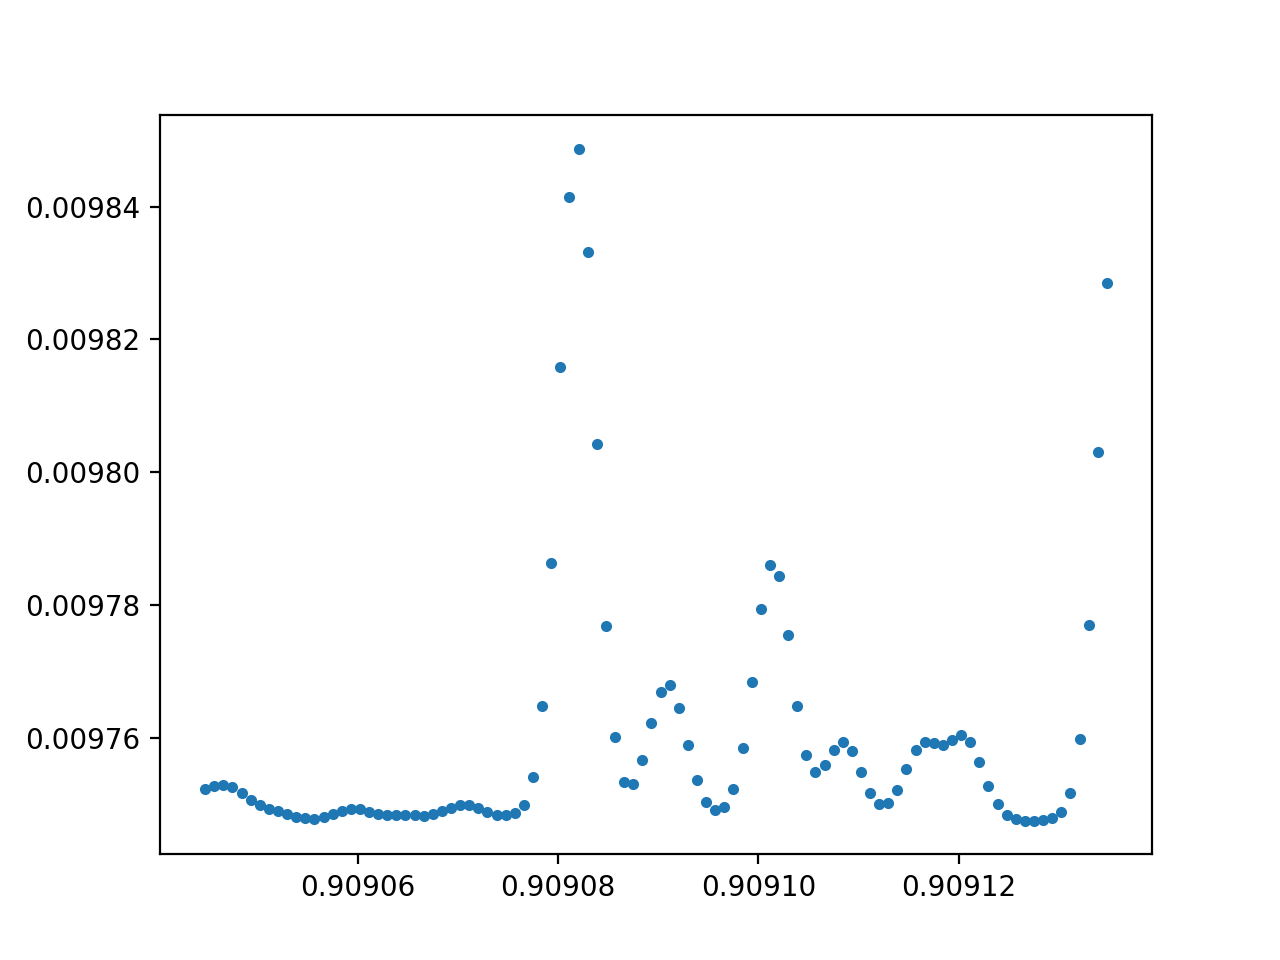

In [6]:
# QUick check
plt.plot(wv_high[10000:10100], model_high[10000:10100], ".")

In [7]:
# %%
pl_name = 'WASP-127 b'

# --- Data parameters
pl_kwargs = {}
obs = Observations(name=pl_name, pl_kwargs=pl_kwargs)
planet = obs.planet
Kp_scale = (planet.M_pl / planet.M_star).decompose().value

Getting WASP-127 b from ExoFile


/home/adb/.venvs/starships_env_noPRT/lib/python3.9/site-packages/exofile/archive.py:351: GetLocalFileWarning: DID NOT READ CUSTOM FILE. FileNotFoundError has occur when trying to query/read custom file.
  warn(GetLocalFileWarning(file="custom file", err=e))


In [48]:
kind_trans = 'transmission'

# - Which sequences are taken (always take only 1)
do_tr = [1]

# - Selecting bad exposures if wanted/needed
bad_indexs = None

## --- Additionnal global variables
inj_alpha = 'ones'
idx_orders = slice(None)
nolog = True

# Choose over which axis the logl is summed.
# -1 (or equivalently 2) should always be present (sum over spectral axis)
# It is possible to sum over multiple axis, like orders and spectra
# with (-2, -1) or equivalently, (1, 2).
axis_sum = -1  # axis along which the logl is summed.

# -----------------------------------------------------------
# LOAD HIGHRES DATA
data_info, data_trs = pl_obs.load_sequences(high_res_file_stem, do_tr, path=high_res_path)
data_info['bad_indexs'] = bad_indexs

Reading: /scratch/adb/DataAnalysis/SPIRou/Reductions/WASP-127b_genest/retrieval_input_3-pc_mask_wings90_tr1_data_trs_0.npz


In [49]:
(in_transit, ) = np.nonzero(data_info['trall_alpha_frac'] > 0.8)

In [84]:
# Pre-compute all values for the logl that are independent of the model, for all orders.
uncert_sum = np.sum(np.ma.log(data_trs['0']['noise'][:, idx_orders]), axis=axis_sum)
s2f= np.sum(data_trs['0']['flux'][:, idx_orders]**2, axis=axis_sum)

In [83]:
# Save (big) arrays that will be shared between processes.
# NOTE: Their values must not be changed by the processes.
out = [(obj, key) for key, obj in data_trs['0'].items()
       if isinstance(obj, np.ndarray)]
shared_arrays, shared_keys = zip(*out)  # transpose result
# Convert to object array
shared_arrays = np.array(shared_arrays, dtype=object)

# If non array objects are needed, it is better to define them separately (below)
# as global variables.
pca = data_trs['0']['pca']

# Define util functions to get the index of a key in the shared arrays.
def get_shared_array_index(*args):
    """Get the index of a key in the shared arrays"""
    idx_list = [shared_keys.index(key) for key in args]
    return idx_list
    

# Play with transit  rotation kernel

In [54]:
from starships.spectrum import RotKerTransitCloudy

In [55]:
planet.period.to('d')

<Quantity [4.17806203] d>

In [14]:
omega = 1. / planet.period
rot_ker_obj = RotKerTransitCloudy(planet.R_pl.to(u.R_jup), planet.M_pl, planet.Tp, omega,
                                  100000., right_val=0.5, step_smooth=250)

<IPython.core.display.Javascript object>


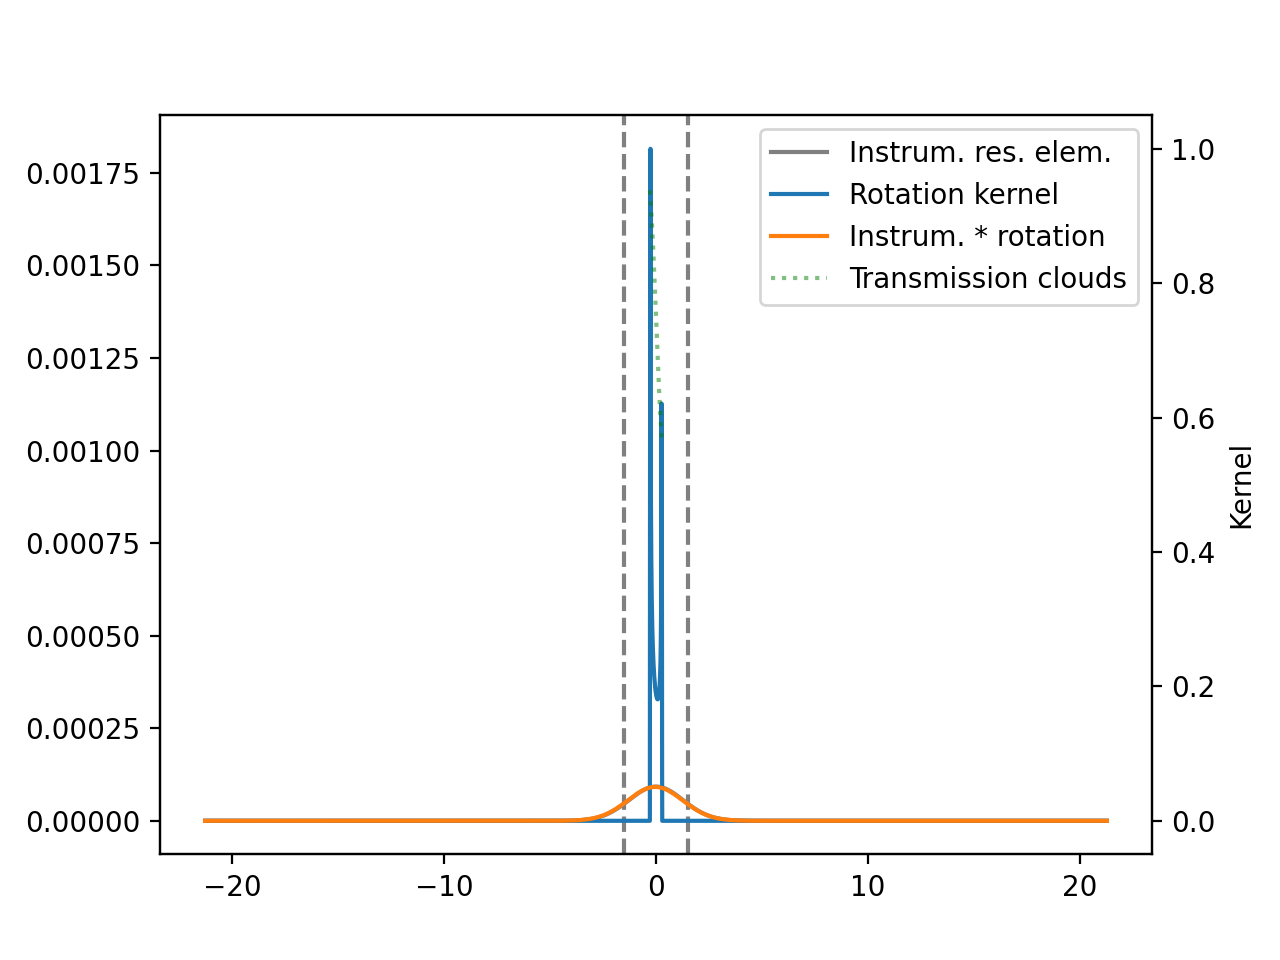

In [16]:
rot_ker_obj.show(norm=True)

In [21]:
R_sampling = 400000.  # Sampling resolution of nirps
profil = rot_ker_obj.resample(R_sampling, n_os=1000, pad=7, norm=True)

In [22]:
model_conv = np.convolve(model_high, profil, mode='same')

<IPython.core.display.Javascript object>


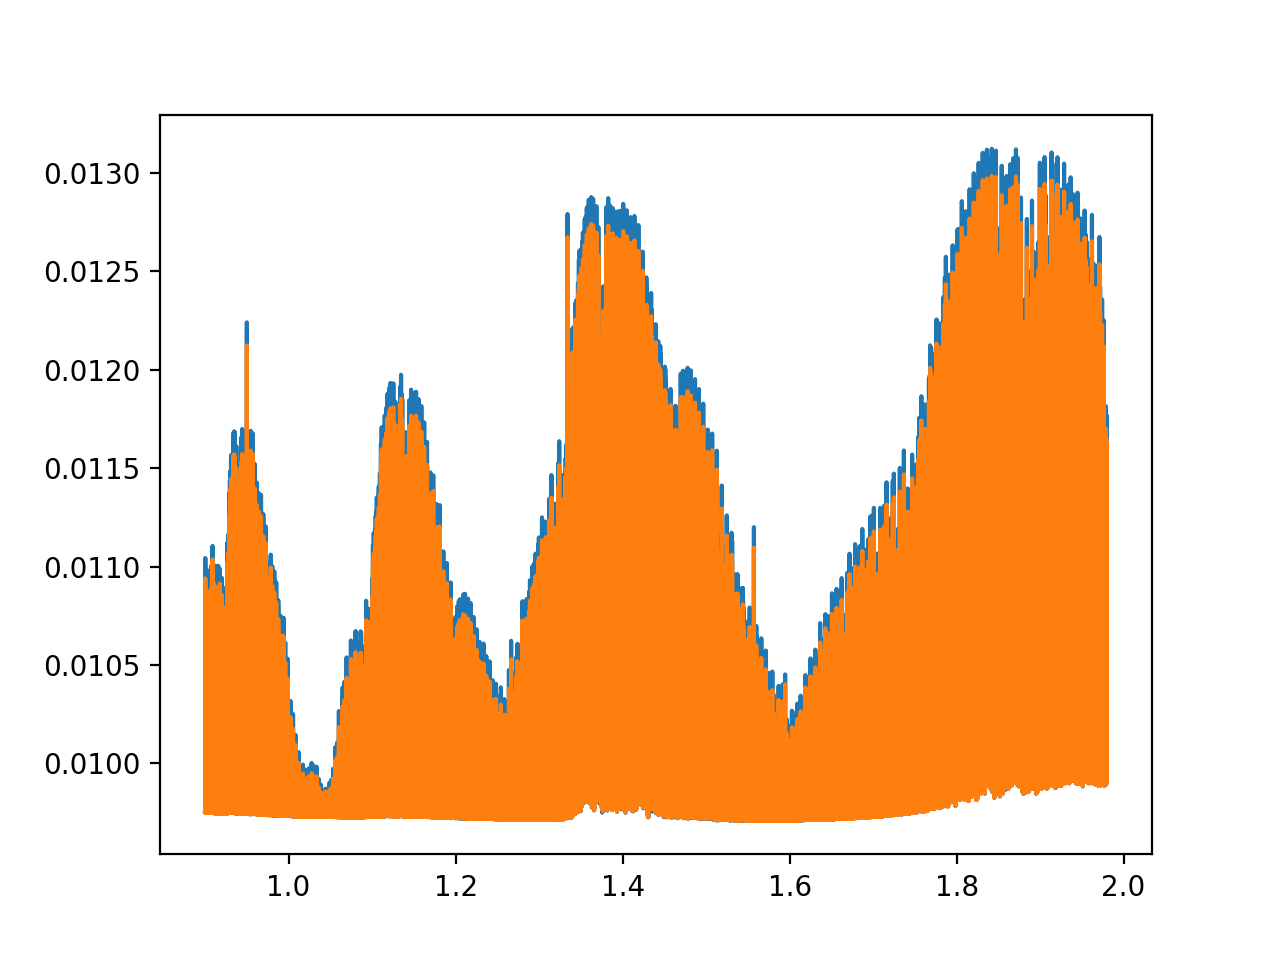

In [23]:

plt.plot(wv_high, model_high)
plt.plot(wv_high[15:-15], model_conv[15:-15])

# Fit the rotation kernel
We want to fit the omega (rotation frequency) and the fraction of clouds on the right hemisphere

## Use the same chi2 computation

In [40]:
def calc_chi2_terms(model, idx_ord=None, axis=None):
    """Compute the model dependent terms of the chi2."""
    
    # Get values from global variables if not provided.
    if idx_ord is None:
        idx_ord = idx_orders
        
    if axis is None:
        axis = axis_sum
        
    # Get the index of the shared arrays and the arrays themselves.
    idx_list = get_shared_array_index('flux', 'noise')
    flux, noise = shared_arrays[idx_list]
    
    # Divide model by the uncertainty
    # NOTE: flux is already divided by the uncertainty.
    model = model[:, idx_ord] / noise[:, idx_ord]

    # Compute each terms of the chi2
    f_x_g = np.ma.sum(model * flux[:, idx_ord], axis=axis) 
    s2g = np.ma.sum(model**2, axis=axis)

    return f_x_g, s2g
    

## Prepare for dynesty

In [103]:
import dynesty
from dynesty import plotting as dyplot
import dynesty.pool as dypool

# seed the random number generator
rstate = np.random.default_rng(736109)

In [100]:
####################################################
# --- Prepare for retrieval
####################################################

# --- Define the prior functions.
# NOTE: the first argument of the prior function must be the value of the parameter.

# Define our uniform prior.
def uniform_prior(val, low, high):

    out = (high - low) * val + low

    return out

def log_uniform_prior(val, low, high):

    out = np.exp((high - low) * val + low)

    return out

# --- Define a dictionary of model prior parameters.
# NOTE: the prior function must be defined or imported above.
# NOTE: the first argument of the prior function must be the value of the parameter.
params_prior = dict()
# Structure:
# params_prior['param_name'] = (prior_function, tuple_of_arguments, dictionnary_of_kwargs)
# NOTE: the tuple of arguments is passed after the first argument, which is the value of the parameter.
# NOTE: if there are no kwargs, pass None or an empty dictionnary.
params_prior['v_sys'] = (uniform_prior, (-30.0, 10.0), None)
params_prior['Kp'] = (uniform_prior, (100., 175.0), None)
# params_prior['alpha'] = (uniform_prior, (0., 2.), None)
# params_prior['beta'] = (log_uniform_prior, (-2, 2), None)
params_prior['omega'] = (uniform_prior, (0.5 * 1 / 4, 10. * 1 / 4), None)  # In day^-1
params_prior['clouds_R'] = (uniform_prior, (0., 1.), None)

print(f"Parameters included in the fit: {list(params_prior.keys())}")

Parameters included in the fit: ['v_sys', 'Kp', 'omega', 'clouds_R']


In [36]:
# Define prior transform using the params_prior dictionary.
def ptform(unif_samples):
    """Transforms samples from the unit cube to the parameter space using the params_prior dictionary."""
    
    # Initialize the output array.
    theta = np.zeros(len(params_prior))

    # Loop over the parameters.
    for i, val in enumerate(params_prior.values()):
        # Get the prior function and its arguments.
        prior_func, args, kwargs = val
        if kwargs is None:
            kwargs = dict()
        # Transform the uniform samples to the parameter space.
        theta[i] = prior_func(unif_samples[i], *args, **kwargs)

    return theta

In [98]:
R_nirps = 100000.
R_sampling = 400000.

# Define the log likelihood function.
def log_like(theta):
    
    # Get the parameters and unpack them in a dictionnary for clarity.
    theta_dict = {key: val for key, val in zip(params_prior.keys(), theta)}
    
    # Apply rotation kernel
    rot_ker_obj = RotKerTransitCloudy(planet.R_pl.to(u.R_jup), planet.M_pl, planet.Tp,
                                      theta_dict['omega'] * u.Unit('1/d'),
                                      R_nirps,
                                      right_val=theta_dict['clouds_R'],
                                      step_smooth=250)
    profil = rot_ker_obj.resample(R_sampling, n_os=1000, pad=7, norm=True)
    model_conv = np.convolve(model_high, profil, mode='same')
    
    # --- Computing the logL for all sequences
    # We need from data_tr: RV_const, t_start, wave, sep, pca, params.
    idx_list = get_shared_array_index('RV_const', 't_start', 'wave', 'sep', 'params')
    rv_const, t_start, wave, sep, params = shared_arrays[idx_list]
    
    vrp_orb = rv_theo_t(theta_dict['Kp'], t_start * u.d, planet.mid_tr,
                        planet.period, plnt=True).value
    
    
    # Get the model sequence.
    n_pc = int(params[5])
    velocities = theta_dict['v_sys'] + vrp_orb - vrp_orb * Kp_scale + rv_const
    model_seq = corr.gen_model_sequence_noinj(velocities,
                                              data_wave=wave,
                                              data_sep=sep,
                                              data_pca=pca,
                                              data_npc=n_pc,
                                              planet=planet,
                                              model_wave=wv_high[20:-20],
                                              model_spec=model_conv[20:-20],
                                              kind_trans=kind_trans,
                                              alpha=data_info['trall_alpha_frac']
                                              )

    # Calculate the log likelihood.
    f_x_g, s2g = calc_chi2_terms(model_seq)
    
    # Get the log likelihood map (function of Kp and vsys).
    alpha = theta_dict.get('alpha', 1.)  # If alpha is not fitted, set to 1.
    logl = get_logl(f_x_g=f_x_g, s2g=s2g, s2f=s2f, N=data_trs['0']['N'], uncert_sum=uncert_sum,
                    idx_orders=None, idx_exposure=in_transit,
                    alpha=alpha, kind='BL', sum_axis=(-2, -1))
    
    return logl

### Test the logl function
Note that it takes some time to run, so the retrieval will take some time too...

In [101]:
%%time
log_like([0., 130., 1./4., 0.9])

CPU times: user 4.06 s, sys: 535 ms, total: 4.6 s
Wall time: 4.74 s


-244214.4364072235

### Run dynesty

In [ ]:
# Run dynesty.
print("Running dynesty...")
n_cpu = 1
n_process = 1 * n_cpu  # Could vary. In this  case it seems more efficient.
n_param = len(params_prior)
with dypool.Pool(n_process, loglike=log_like, prior_transform=ptform) as pool:
    dsampler = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, ndim=n_param,
                                            bound='balls', sample='unif', rstate=rstate, pool=pool)

    dsampler.run_nested(dlogz_init=0.01, nlive_init=500, nlive_batch=500,
                        wt_kwargs={'pfrac': 1.0}, stop_kwargs={'pfrac': 1.0},
                        print_progress=True, maxiter=3000)
    
    dres_p = dsampler.results


Running dynesty...


It takes forever with only one core, so may be better to run in a dedicated python code... 
Or with more cpus, but I'm not sure how to make it work with notebooks